In [1]:
import numpy as np
from scipy import misc, fft as scipy_fft
from matplotlib import pyplot, colors, cm

colors.get_named_colors_mapping().update({
    'lfd:signal': "#4e79a7",
    'lfd:pupil': "#59a14f",
    'lfd:retina': "#e15759",
})

def sampling_coordinates(n, s):
    return (np.arange(n) - (n-1)/2) * s/n

def evaluate(x, xi, amplitudes, phases):
    return np.sum(amplitudes * np.cos(2.0 * np.pi * xi * x[:, np.newaxis] + phases), axis=-1)

def spatial_display_to_eye(x_a, x_b, z_a, z_b, z_r, z_f):
    x_r = (1 - z_b/z_f) * z_r/(z_a - z_b) * x_a + (1 - z_a/z_f) * z_r/(z_b - z_a) * x_b
    x_p = z_b/(z_b - z_a) * x_a + z_a/(z_a - z_b) * x_b
    return x_r, x_p

def spatial_eye_to_display(x_r, x_p, z_a, z_b, z_r, z_f):
    x_a = (z_a/z_r) * x_r + (1 - z_a/z_f) * x_p
    x_b = (z_b/z_r) * x_r + (1 - z_b/z_f) * x_p
    return x_a, x_b

def frequency_display_to_eye(xi_a, xi_b, z_a, z_b, z_r, z_f):
    xi_r = (z_a/z_r) * xi_a + (z_b/z_r) * xi_b
    xi_p = (1 - z_a/z_f) * xi_a + (1 - z_b/z_f) * xi_b
    return xi_r, xi_p

def frequency_eye_to_display(xi_r, xi_p, z_a, z_b, z_r, z_f):
    xi_a = (1 - z_b/z_f) * z_r/(z_a - z_b) * xi_r + z_b/(z_b - z_a) * xi_p
    xi_b = (1 - z_a/z_f) * z_r/(z_b - z_a) * xi_r + z_a/(z_a - z_b) * xi_p
    return xi_a, xi_b

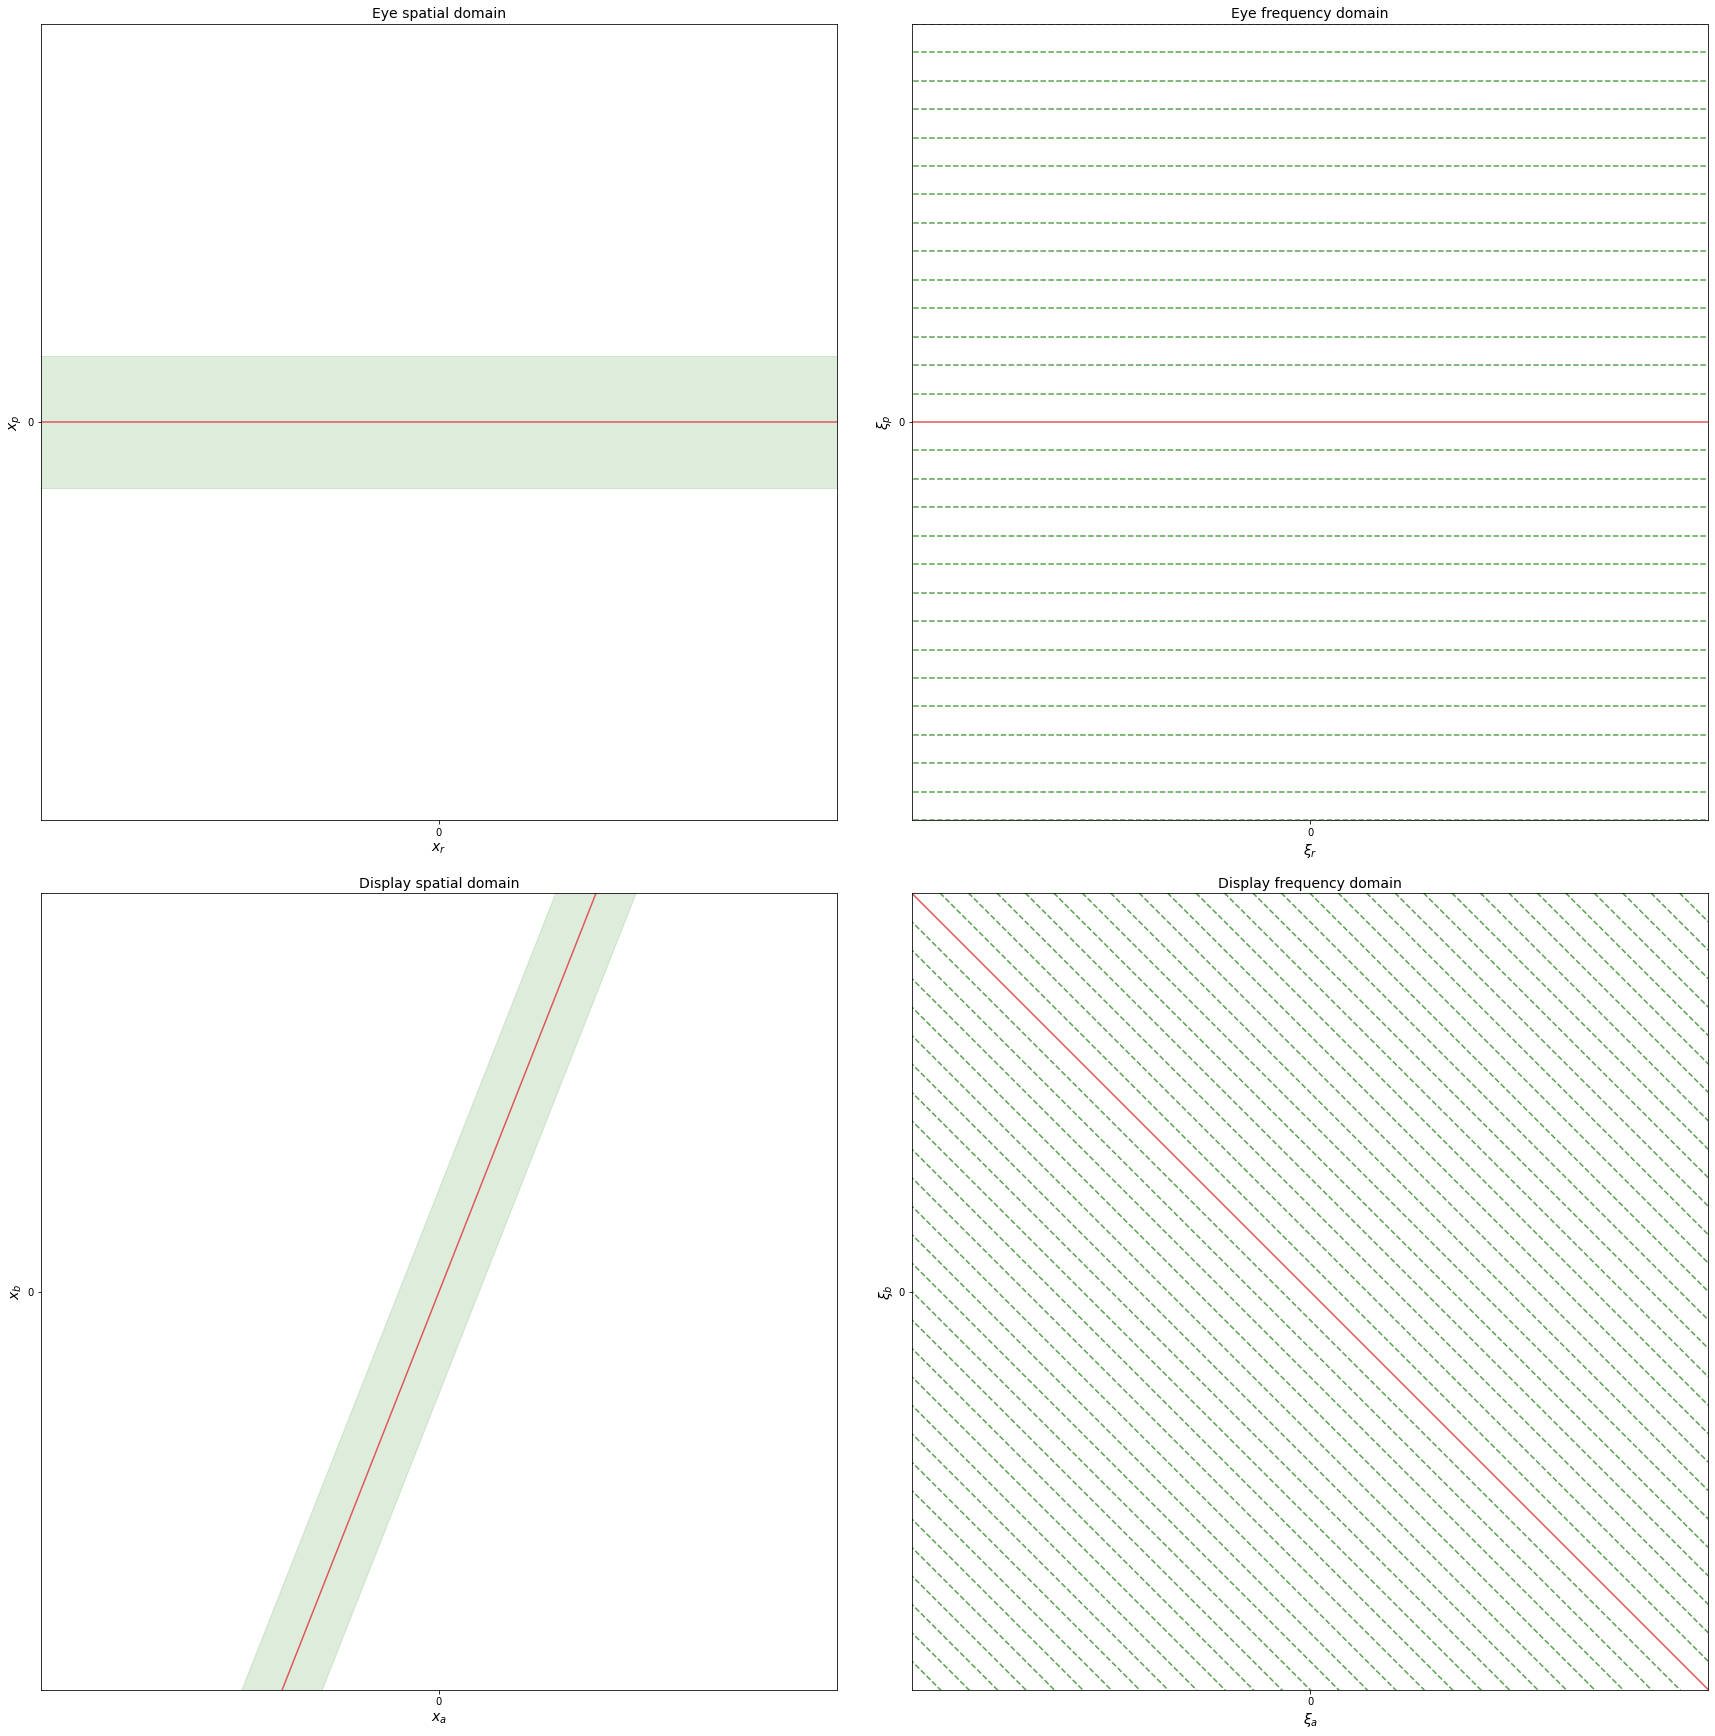

In [2]:
z_a = 13.0
z_b = 33.0
z_r = -17.0
z_f = np.inf

n_a = 3
n_b = 5
n_r = 15
n_p = 99

s_p = 5.0

s_a = s_p
s_b = s_p

s_r = np.abs(z_r/(z_b - z_a)) * s_p

x_r = sampling_coordinates(n_r, s_r)

x_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * s_b), 99 * n_a))
xi_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * n_a/s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * n_b/s_b), 99 * n_a))

window_x_r = (np.array([-s_r/2, -s_r/2, s_r/2, s_r/2]), np.array([100, -100, -100, 100]))
window_x_p = (np.array([100, -100, -100, 100]), np.array([-s_p/2, -s_p/2, s_p/2, s_p/2]))
xi_p = sampling_coordinates(n_p, n_p/s_p)
xi_r = sampling_coordinates(n_r, n_r/s_r)

fig, axs = pyplot.subplots(2, 2, constrained_layout=True, figsize=(24, 24))

axs[0, 0].set_title('Eye spatial domain', fontsize=14)
axs[0, 0].set_xlabel(r'$x_r$', fontsize=14)
axs[0, 0].set_ylabel(r'$x_p$', fontsize=14)
axs[0, 0].set_aspect('equal')
axs[0, 0].set_xticks([0])
axs[0, 0].set_yticks([0])
axs[0, 0].set_xlim(-15.0, 15.0)
axs[0, 0].set_ylim(-15.0, 15.0)

axs[0, 0].plot([-100.0, 100.0], [0.0, 0.0], color='lfd:retina')
axs[0, 0].fill(*window_x_p, alpha=0.2, color='lfd:pupil')

axs[0, 1].set_title('Eye frequency domain', fontsize=14)
axs[0, 1].set_xlabel(r'$\xi_r$', fontsize=14)
axs[0, 1].set_ylabel(r'$\xi_p$', fontsize=14)
axs[0, 1].set_aspect('equal')
axs[0, 1].set_xticks([0])
axs[0, 1].set_yticks([0])
axs[0, 1].set_xlim(-2.8, 2.8)
axs[0, 1].set_ylim(-2.8, 2.8)

axs[0, 1].plot(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), linestyle='dashed', color='lfd:pupil')
axs[0, 1].plot(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), linestyle='dashed', color='lfd:pupil')
axs[0, 1].plot([-100.0, 100.0], [0.0, 0.0], color='lfd:retina')

axs[1, 0].set_title('Display spatial domain', fontsize=14)
axs[1, 0].set_xlabel(r'$x_a$', fontsize=14)
axs[1, 0].set_ylabel(r'$x_b$', fontsize=14)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_xticks([0])
axs[1, 0].set_yticks([0])
axs[1, 0].set_xlim(-15.0, 15.0)
axs[1, 0].set_ylim(-15.0, 15.0)

axs[1, 0].plot(*spatial_eye_to_display(np.array([-100.0, 100.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')
axs[1, 0].fill(*spatial_eye_to_display(*window_x_p, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:pupil')

axs[1, 1].set_title('Display frequency domain', fontsize=14)
axs[1, 1].set_xlabel(r'$\xi_a$', fontsize=14)
axs[1, 1].set_ylabel(r'$\xi_b$', fontsize=14)
axs[1, 1].set_aspect('equal')
axs[1, 1].set_xticks([0])
axs[1, 1].set_yticks([0])
axs[1, 1].set_xlim(-2.8, 2.8)
axs[1, 1].set_ylim(-2.8, 2.8)

axs[1, 1].plot(*frequency_eye_to_display(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
axs[1, 1].plot(*frequency_eye_to_display(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
axs[1, 1].plot(*frequency_eye_to_display(np.array([-100.0, 100.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')

pass

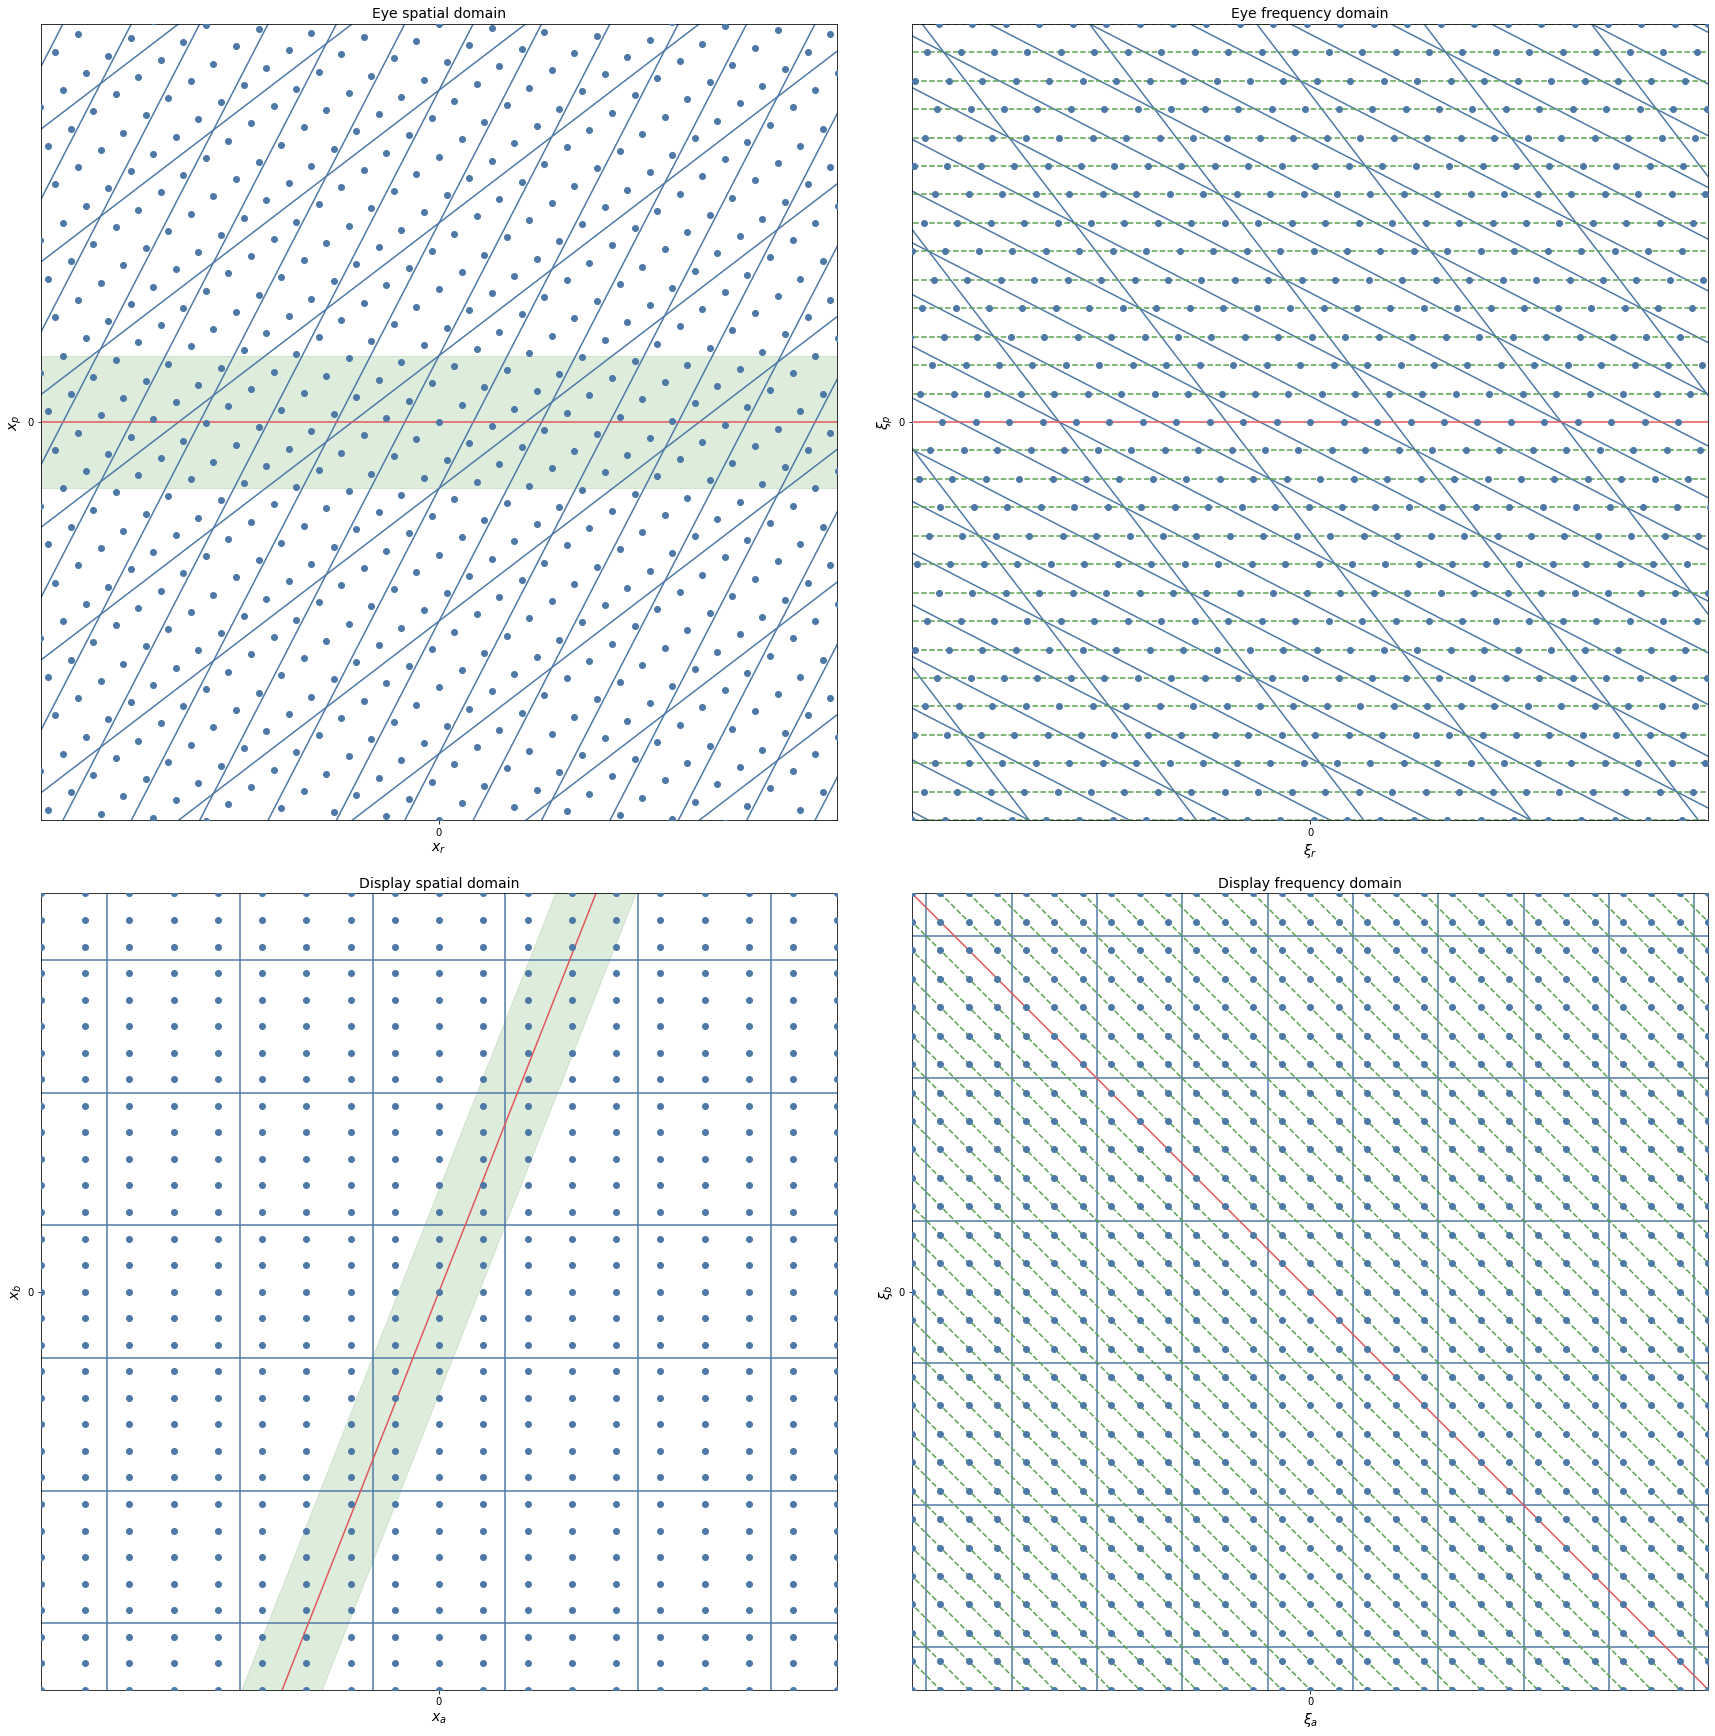

In [3]:
z_a = 13.0
z_b = 33.0
z_r = -17.0
z_f = np.inf

n_a = 3
n_b = 5
n_r = 15
n_p = 99

s_p = 5.0

s_a = s_p
s_b = s_p

s_r = np.abs(z_r/(z_b - z_a)) * s_p

x_r = sampling_coordinates(n_r, s_r)

x_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * s_b), 99 * n_a))
xi_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * n_a/s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * n_b/s_b), 99 * n_a))

window_x_r = (np.array([-s_r/2, -s_r/2, s_r/2, s_r/2]), np.array([100, -100, -100, 100]))
window_x_p = (np.array([100, -100, -100, 100]), np.array([-s_p/2, -s_p/2, s_p/2, s_p/2]))
xi_p = sampling_coordinates(n_p, n_p/s_p)
xi_r = sampling_coordinates(n_r, n_r/s_r)

fig, axs = pyplot.subplots(2, 2, constrained_layout=True, figsize=(24, 24))

axs[0, 0].set_title('Eye spatial domain', fontsize=14)
axs[0, 0].set_xlabel(r'$x_r$', fontsize=14)
axs[0, 0].set_ylabel(r'$x_p$', fontsize=14)
axs[0, 0].set_aspect('equal')
axs[0, 0].set_xticks([0])
axs[0, 0].set_yticks([0])
axs[0, 0].set_xlim(-15.0, 15.0)
axs[0, 0].set_ylim(-15.0, 15.0)

axs[0, 0].scatter(*spatial_display_to_eye(*x_ab, z_a, z_b, z_r, z_f), color='lfd:signal', zorder=3)
axs[0, 0].plot(*spatial_display_to_eye(np.repeat(sampling_coordinates(99, 99 * s_a) - s_a/2, 3), np.tile([-100.0, 100.0, np.nan], 99), z_a, z_b, z_r, z_f), color='lfd:signal')
axs[0, 0].plot(*spatial_display_to_eye(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * s_b) - s_b/2, 3), z_a, z_b, z_r, z_f), color='lfd:signal')
axs[0, 0].plot([-100.0, 100.0], [0.0, 0.0], color='lfd:retina')
axs[0, 0].fill(*window_x_p, alpha=0.2, color='lfd:pupil')

axs[0, 1].set_title('Eye frequency domain', fontsize=14)
axs[0, 1].set_xlabel(r'$\xi_r$', fontsize=14)
axs[0, 1].set_ylabel(r'$\xi_p$', fontsize=14)
axs[0, 1].set_aspect('equal')
axs[0, 1].set_xticks([0])
axs[0, 1].set_yticks([0])
axs[0, 1].set_xlim(-2.8, 2.8)
axs[0, 1].set_ylim(-2.8, 2.8)

axs[0, 1].scatter(*frequency_display_to_eye(*xi_ab, z_a, z_b, z_r, z_f), color='lfd:signal', zorder=3)
axs[0, 1].plot(*frequency_display_to_eye(np.repeat(sampling_coordinates(99, 99 * n_a/s_a) - (n_a/s_a)/2, 3), np.tile([-100.0, 100.0, np.nan], 99), z_a, z_b, z_r, z_f), color='lfd:signal')
axs[0, 1].plot(*frequency_display_to_eye(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * n_b/s_b) - (n_b/s_b)/2, 3), z_a, z_b, z_r, z_f), color='lfd:signal')
axs[0, 1].plot(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), linestyle='dashed', color='lfd:pupil')
axs[0, 1].plot(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), linestyle='dashed', color='lfd:pupil')
axs[0, 1].plot([-100.0, 100.0], [0.0, 0.0], color='lfd:retina')

axs[1, 0].set_title('Display spatial domain', fontsize=14)
axs[1, 0].set_xlabel(r'$x_a$', fontsize=14)
axs[1, 0].set_ylabel(r'$x_b$', fontsize=14)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_xticks([0])
axs[1, 0].set_yticks([0])
axs[1, 0].set_xlim(-15.0, 15.0)
axs[1, 0].set_ylim(-15.0, 15.0)

axs[1, 0].scatter(*x_ab, color='lfd:signal', zorder=3)
axs[1, 0].plot(np.repeat(sampling_coordinates(99, 99 * s_a) - s_a/2, 3), np.tile([-100.0, 100.0, np.nan], 99), color='lfd:signal')
axs[1, 0].plot(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * s_b) - s_b/2, 3), color='lfd:signal')
axs[1, 0].plot(*spatial_eye_to_display(np.array([-100.0, 100.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')
axs[1, 0].fill(*spatial_eye_to_display(*window_x_p, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:pupil')

axs[1, 1].set_title('Display frequency domain', fontsize=14)
axs[1, 1].set_xlabel(r'$\xi_a$', fontsize=14)
axs[1, 1].set_ylabel(r'$\xi_b$', fontsize=14)
axs[1, 1].set_aspect('equal')
axs[1, 1].set_xticks([0])
axs[1, 1].set_yticks([0])
axs[1, 1].set_xlim(-2.8, 2.8)
axs[1, 1].set_ylim(-2.8, 2.8)

axs[1, 1].scatter(*xi_ab, color='lfd:signal', zorder=3)
axs[1, 1].plot(np.repeat(sampling_coordinates(99, 99 * n_a/s_a) - (n_a/s_a)/2, 3), np.tile([-100.0, 100.0, np.nan], 99), color='lfd:signal')
axs[1, 1].plot(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * n_b/s_b) - (n_b/s_b)/2, 3), color='lfd:signal')
axs[1, 1].plot(*frequency_eye_to_display(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
axs[1, 1].plot(*frequency_eye_to_display(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
axs[1, 1].plot(*frequency_eye_to_display(np.array([-100.0, 100.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')

pass

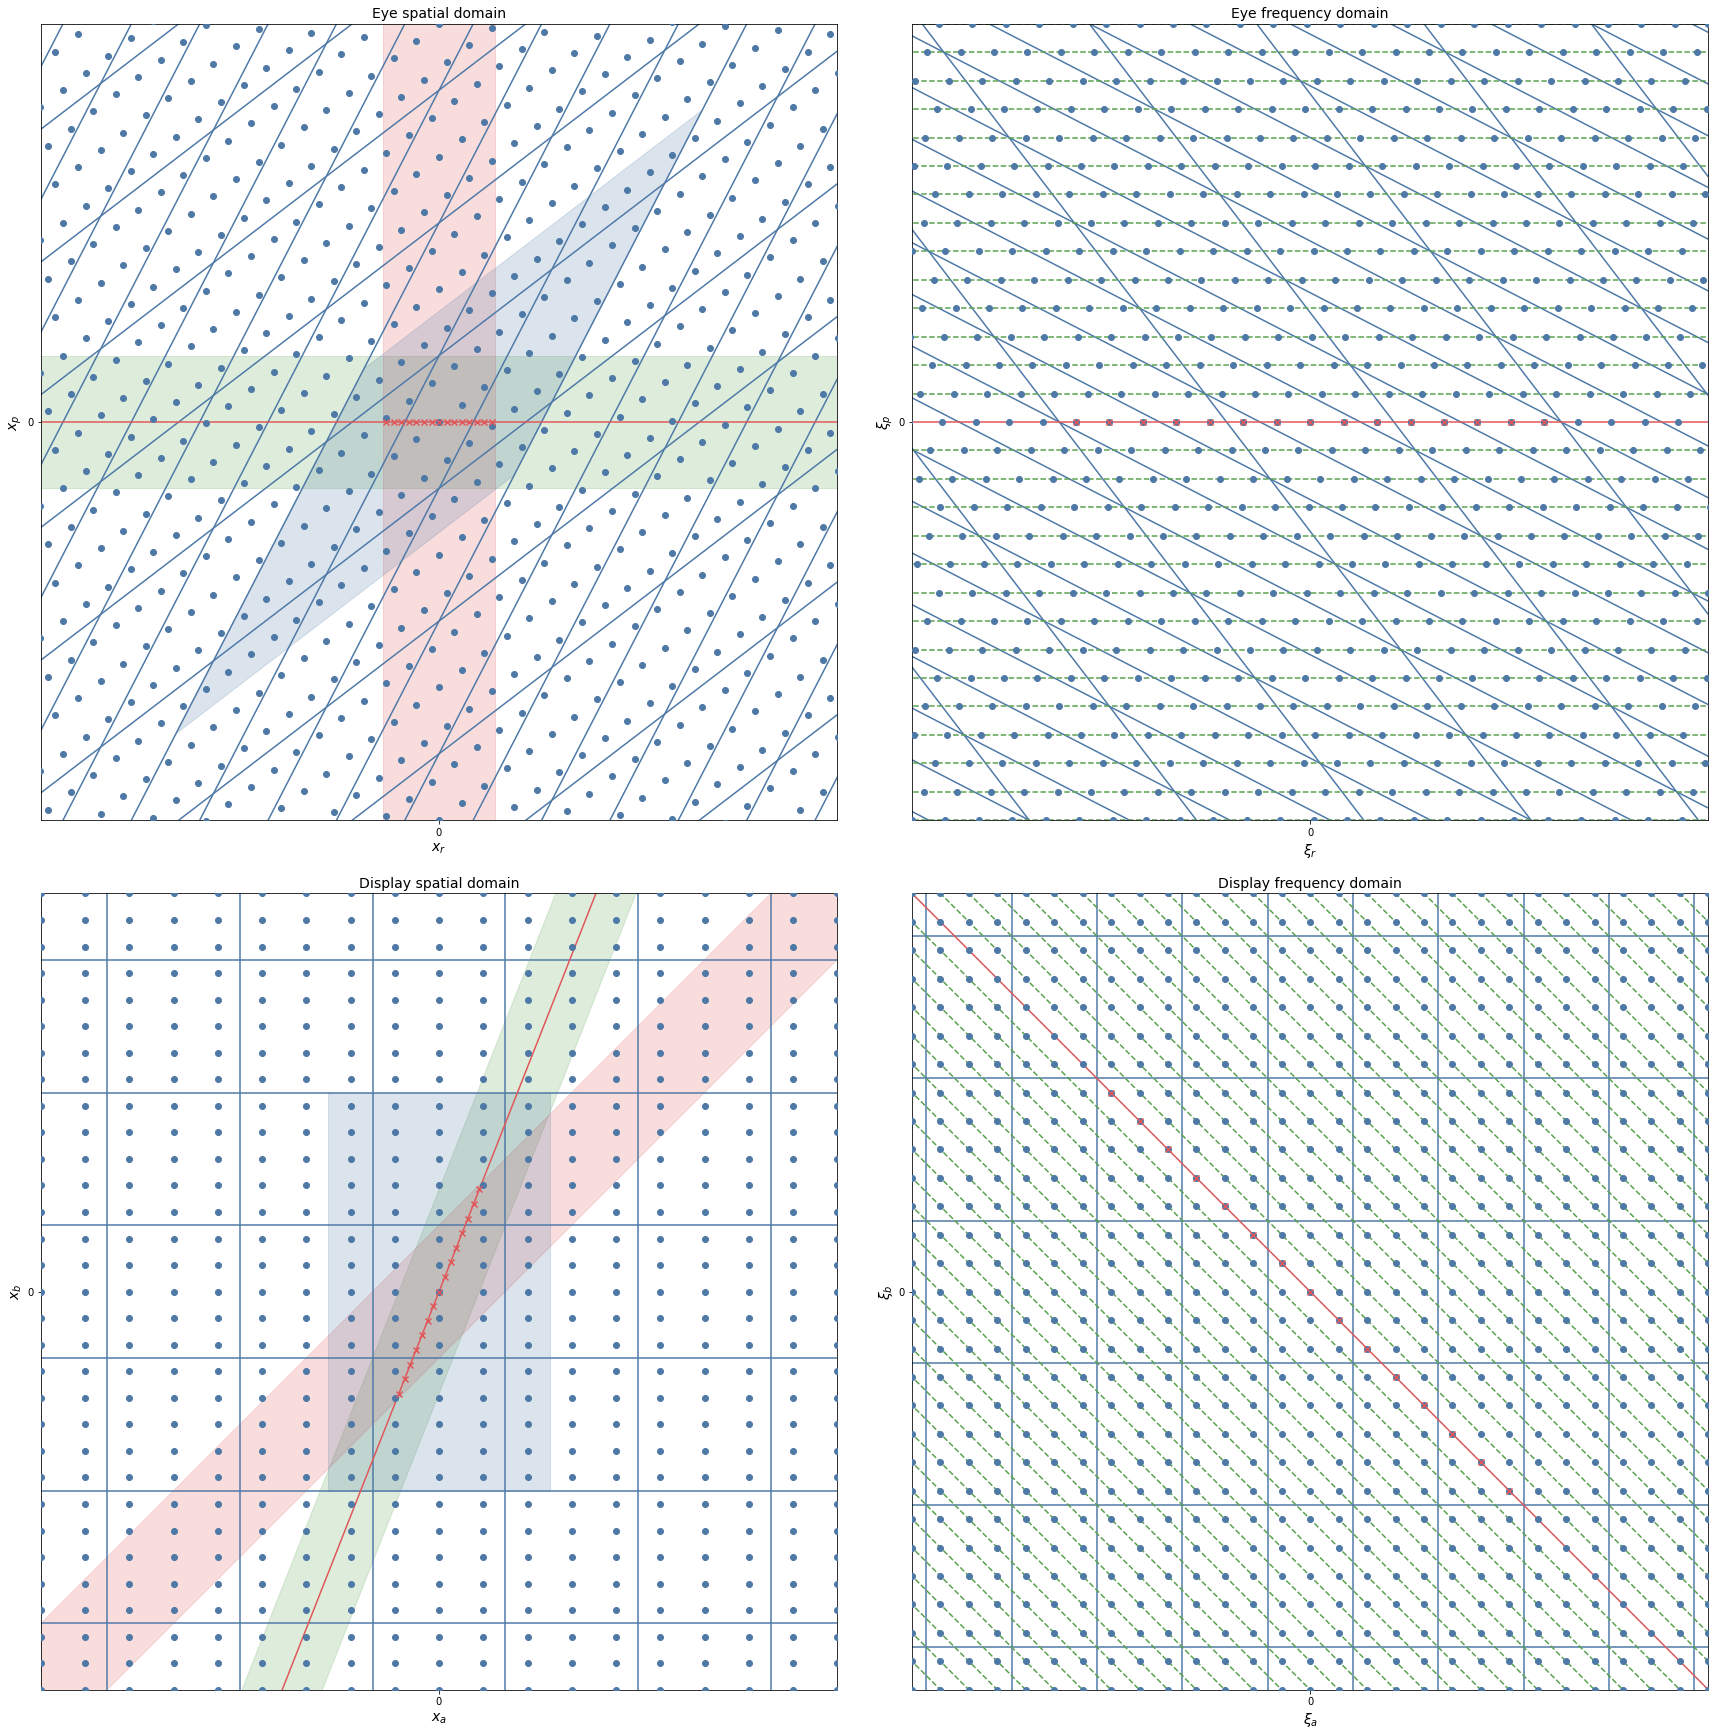

In [4]:
z_a = 13.0
z_b = 33.0
z_r = -17.0
z_f = np.inf

n_a = 3
n_b = 5
n_r = 15
n_p = 99

s_p = 5.0

s_a = s_p
s_b = s_p

s_r = np.abs(z_r/(z_b - z_a)) * s_p

nn_a = np.ceil(((s_r * abs(z_a/z_r) + s_p) * n_a/s_a - 1)/2).astype(np.int8) * 2 + 1
nn_b = np.ceil(((s_r * abs(z_b/z_r) + s_p) * n_b/s_b - 1)/2).astype(np.int8) * 2 + 1

ss_a = nn_a * s_a/n_a
ss_b = nn_b * s_b/n_b

x_r = sampling_coordinates(n_r, s_r)

x_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * s_b), 99 * n_a))
xi_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * n_a/s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * n_b/s_b), 99 * n_a))

window_x_r = (np.array([-s_r/2, -s_r/2, s_r/2, s_r/2]), np.array([100, -100, -100, 100]))
window_x_p = (np.array([100, -100, -100, 100]), np.array([-s_p/2, -s_p/2, s_p/2, s_p/2]))
xi_p = sampling_coordinates(n_p, n_p/s_p)
xi_r = sampling_coordinates(n_r, n_r/s_r)

fig, axs = pyplot.subplots(2, 2, constrained_layout=True, figsize=(24, 24))

axs[0, 0].set_title('Eye spatial domain', fontsize=14)
axs[0, 0].set_xlabel(r'$x_r$', fontsize=14)
axs[0, 0].set_ylabel(r'$x_p$', fontsize=14)
axs[0, 0].set_aspect('equal')
axs[0, 0].set_xticks([0])
axs[0, 0].set_yticks([0])
axs[0, 0].set_xlim(-15.0, 15.0)
axs[0, 0].set_ylim(-15.0, 15.0)

axs[0, 0].scatter(*spatial_display_to_eye(*x_ab, z_a, z_b, z_r, z_f), color='lfd:signal', zorder=3)
axs[0, 0].scatter(x_r, [0.0]*n_r, color='lfd:retina', marker='x', zorder=3)
axs[0, 0].plot(*spatial_display_to_eye(np.repeat(sampling_coordinates(99, 99 * s_a) - s_a/2, 3), np.tile([-100.0, 100.0, np.nan], 99), z_a, z_b, z_r, z_f), color='lfd:signal')
axs[0, 0].plot(*spatial_display_to_eye(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * s_b) - s_b/2, 3), z_a, z_b, z_r, z_f), color='lfd:signal')
axs[0, 0].plot([-100.0, 100.0], [0.0, 0.0], color='lfd:retina')
axs[0, 0].fill(*window_x_p, alpha=0.2, color='lfd:pupil')
axs[0, 0].fill(*window_x_r, alpha=0.2, color='lfd:retina')
axs[0, 0].fill(*spatial_display_to_eye(np.array([1, -1, -1, 1]) * ss_a/2, np.array([-1, -1, 1, 1]) * ss_b/2, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:signal')

axs[0, 1].set_title('Eye frequency domain', fontsize=14)
axs[0, 1].set_xlabel(r'$\xi_r$', fontsize=14)
axs[0, 1].set_ylabel(r'$\xi_p$', fontsize=14)
axs[0, 1].set_aspect('equal')
axs[0, 1].set_xticks([0])
axs[0, 1].set_yticks([0])
axs[0, 1].set_xlim(-2.8, 2.8)
axs[0, 1].set_ylim(-2.8, 2.8)

axs[0, 1].scatter(*frequency_display_to_eye(*xi_ab, z_a, z_b, z_r, z_f), color='lfd:signal', zorder=3)
axs[0, 1].scatter(xi_r, [0.0]*n_r, color='lfd:retina', marker='x', zorder=3)
axs[0, 1].plot(*frequency_display_to_eye(np.repeat(sampling_coordinates(99, 99 * n_a/s_a) - (n_a/s_a)/2, 3), np.tile([-100.0, 100.0, np.nan], 99), z_a, z_b, z_r, z_f), color='lfd:signal')
axs[0, 1].plot(*frequency_display_to_eye(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * n_b/s_b) - (n_b/s_b)/2, 3), z_a, z_b, z_r, z_f), color='lfd:signal')
axs[0, 1].plot(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), linestyle='dashed', color='lfd:pupil')
axs[0, 1].plot(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), linestyle='dashed', color='lfd:pupil')
axs[0, 1].plot([-100.0, 100.0], [0.0, 0.0], color='lfd:retina')

axs[1, 0].set_title('Display spatial domain', fontsize=14)
axs[1, 0].set_xlabel(r'$x_a$', fontsize=14)
axs[1, 0].set_ylabel(r'$x_b$', fontsize=14)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_xticks([0])
axs[1, 0].set_yticks([0])
axs[1, 0].set_xlim(-15.0, 15.0)
axs[1, 0].set_ylim(-15.0, 15.0)

axs[1, 0].scatter(*x_ab, color='lfd:signal', zorder=3)
axs[1, 0].scatter(*spatial_eye_to_display(x_r, 0.0, z_a, z_b, z_r, z_f), color='lfd:retina', marker='x', zorder=3)
axs[1, 0].plot(np.repeat(sampling_coordinates(99, 99 * s_a) - s_a/2, 3), np.tile([-100.0, 100.0, np.nan], 99), color='lfd:signal')
axs[1, 0].plot(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * s_b) - s_b/2, 3), color='lfd:signal')
axs[1, 0].plot(*spatial_eye_to_display(np.array([-100.0, 100.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')
axs[1, 0].fill(*spatial_eye_to_display(*window_x_p, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:pupil')
axs[1, 0].fill(*spatial_eye_to_display(*window_x_r, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:retina')
axs[1, 0].fill(np.array([1, -1, -1, 1]) * ss_a/2, np.array([-1, -1, 1, 1]) * ss_b/2, alpha=0.2, color='lfd:signal')

axs[1, 1].set_title('Display frequency domain', fontsize=14)
axs[1, 1].set_xlabel(r'$\xi_a$', fontsize=14)
axs[1, 1].set_ylabel(r'$\xi_b$', fontsize=14)
axs[1, 1].set_aspect('equal')
axs[1, 1].set_xticks([0])
axs[1, 1].set_yticks([0])
axs[1, 1].set_xlim(-2.8, 2.8)
axs[1, 1].set_ylim(-2.8, 2.8)

axs[1, 1].scatter(*xi_ab, color='lfd:signal', zorder=3)
axs[1, 1].scatter(*frequency_eye_to_display(xi_r, 0.0, z_a, z_b, z_r, z_f), color='lfd:retina', marker='x', zorder=3)
axs[1, 1].plot(np.repeat(sampling_coordinates(99, 99 * n_a/s_a) - (n_a/s_a)/2, 3), np.tile([-100.0, 100.0, np.nan], 99), color='lfd:signal')
axs[1, 1].plot(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * n_b/s_b) - (n_b/s_b)/2, 3), color='lfd:signal')
axs[1, 1].plot(*frequency_eye_to_display(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
axs[1, 1].plot(*frequency_eye_to_display(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
axs[1, 1].plot(*frequency_eye_to_display(np.array([-100.0, 100.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')

pass

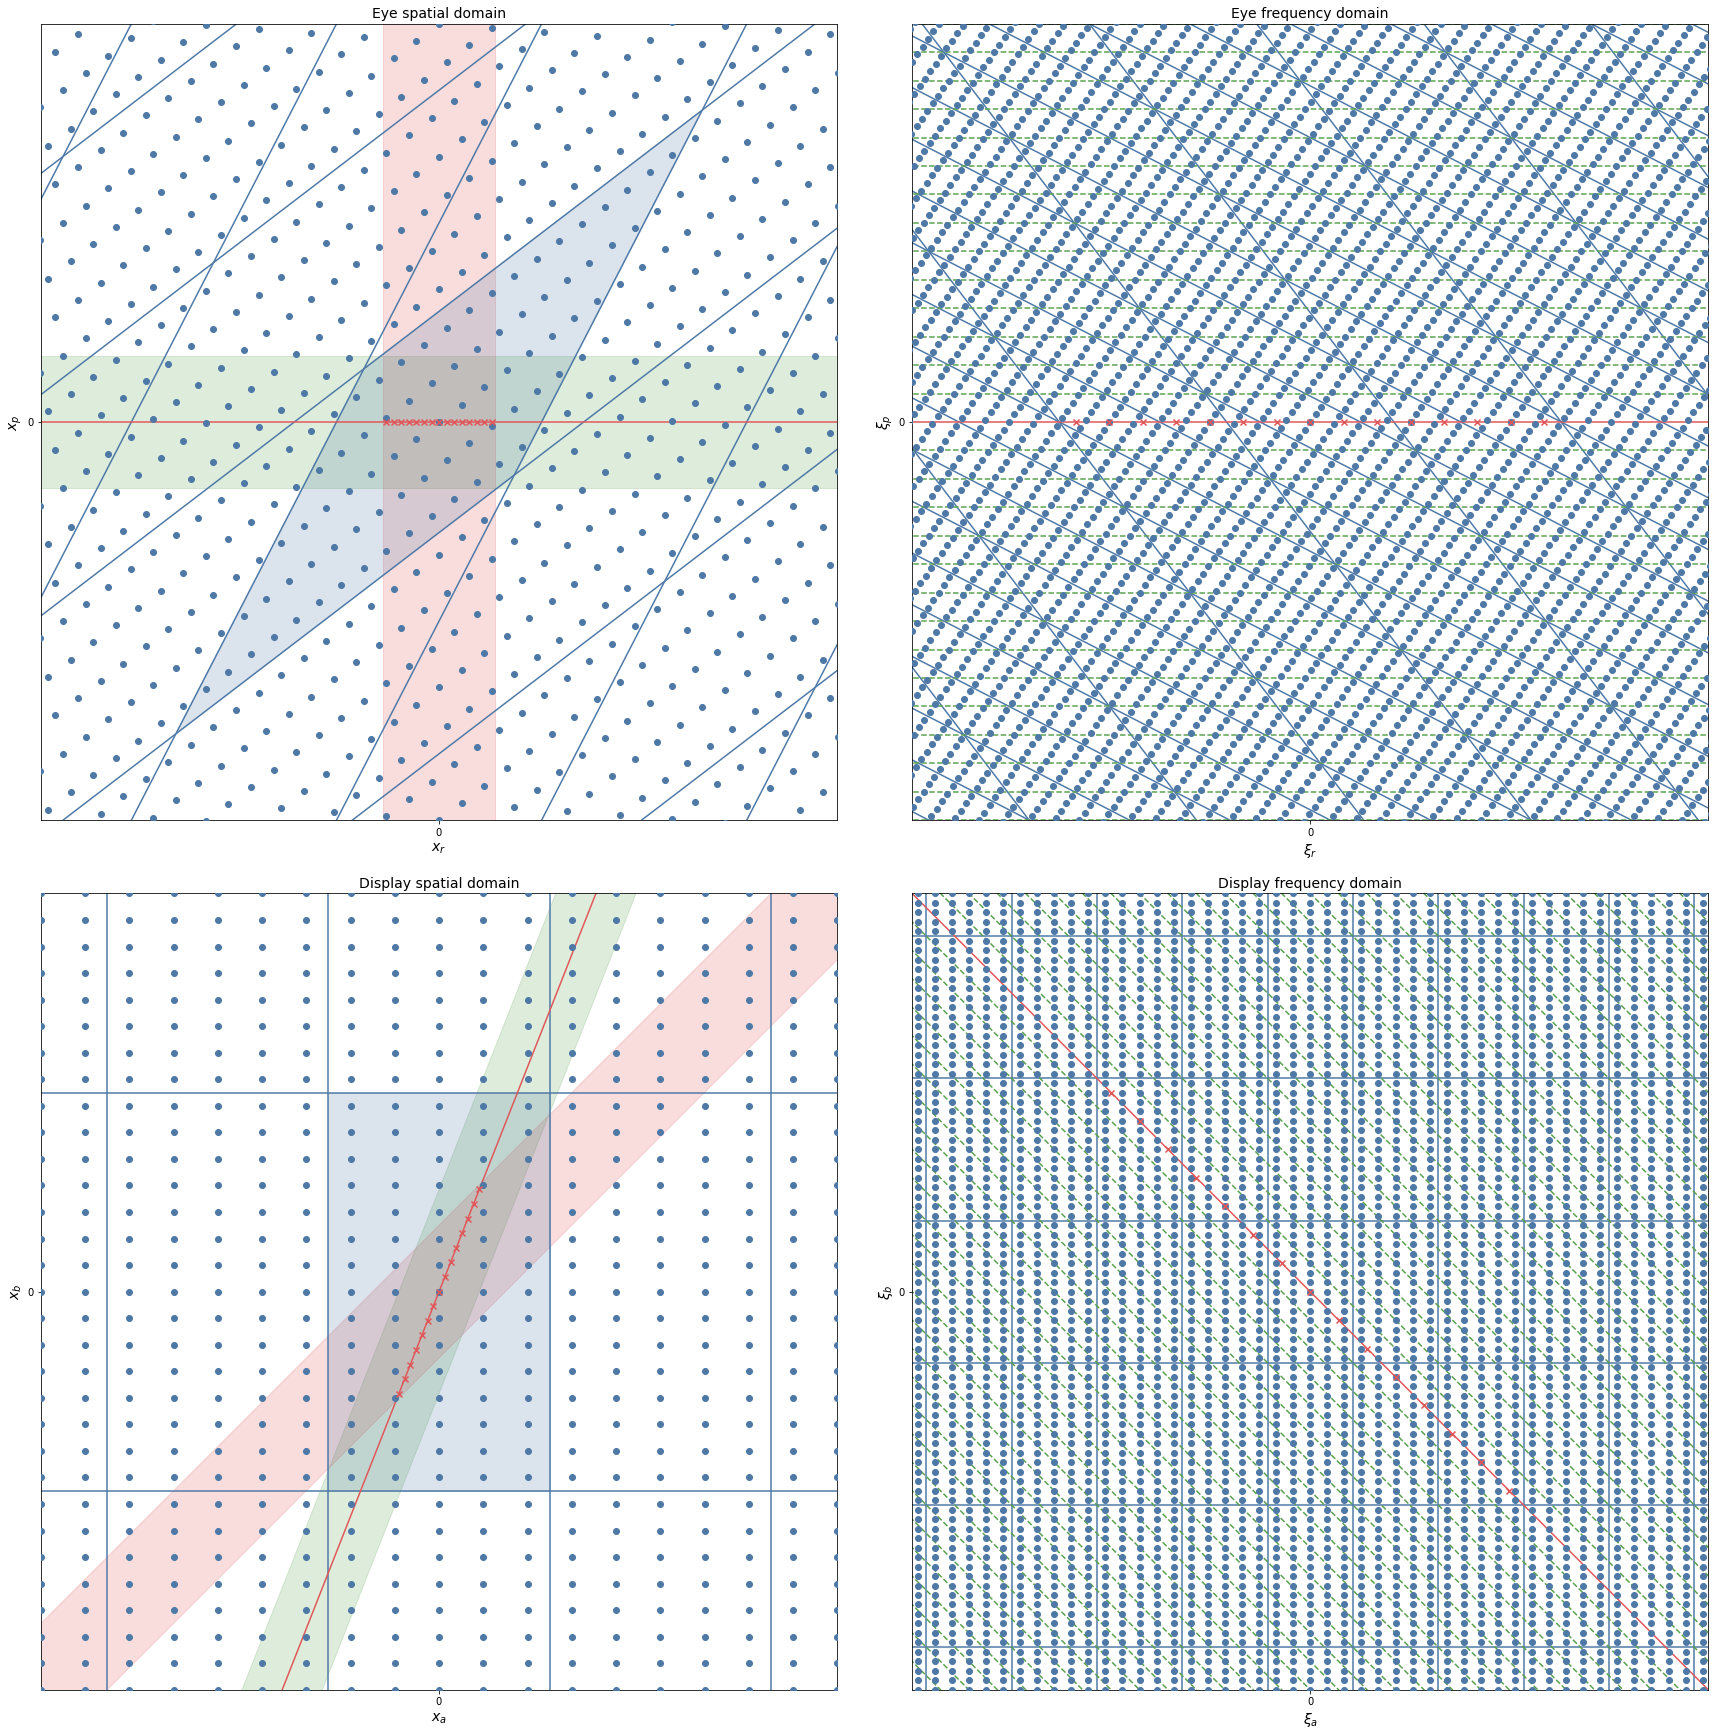

In [5]:
z_a = 13.0
z_b = 33.0
z_r = -17.0
z_f = np.inf

n_a = 3
n_b = 5
n_r = 15
n_p = 99

s_p = 5.0

s_a = s_p
s_b = s_p

s_r = np.abs(z_r/(z_b - z_a)) * s_p

nn_a = np.ceil(((s_r * abs(z_a/z_r) + s_p) * n_a/s_a - 1)/2).astype(np.int8) * 2 + 1
nn_b = np.ceil(((s_r * abs(z_b/z_r) + s_p) * n_b/s_b - 1)/2).astype(np.int8) * 2 + 1

ss_a = nn_a * s_a/n_a
ss_b = nn_b * s_b/n_b

n_a = nn_a
n_b = nn_b
s_a = ss_a
s_b = ss_b

x_r = sampling_coordinates(n_r, s_r)

x_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * s_b), 99 * n_a))
xi_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * n_a/s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * n_b/s_b), 99 * n_a))

window_x_r = (np.array([-s_r/2, -s_r/2, s_r/2, s_r/2]), np.array([100, -100, -100, 100]))
window_x_p = (np.array([100, -100, -100, 100]), np.array([-s_p/2, -s_p/2, s_p/2, s_p/2]))
xi_p = sampling_coordinates(n_p, n_p/s_p)
xi_r = sampling_coordinates(n_r, n_r/s_r)

fig, axs = pyplot.subplots(2, 2, constrained_layout=True, figsize=(24, 24))

axs[0, 0].set_title('Eye spatial domain', fontsize=14)
axs[0, 0].set_xlabel(r'$x_r$', fontsize=14)
axs[0, 0].set_ylabel(r'$x_p$', fontsize=14)
axs[0, 0].set_aspect('equal')
axs[0, 0].set_xticks([0])
axs[0, 0].set_yticks([0])
axs[0, 0].set_xlim(-15.0, 15.0)
axs[0, 0].set_ylim(-15.0, 15.0)

axs[0, 0].scatter(*spatial_display_to_eye(*x_ab, z_a, z_b, z_r, z_f), color='lfd:signal', zorder=3)
axs[0, 0].scatter(x_r, [0.0]*n_r, color='lfd:retina', marker='x', zorder=3)
axs[0, 0].plot(*spatial_display_to_eye(np.repeat(sampling_coordinates(99, 99 * s_a) - s_a/2, 3), np.tile([-100.0, 100.0, np.nan], 99), z_a, z_b, z_r, z_f), color='lfd:signal')
axs[0, 0].plot(*spatial_display_to_eye(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * s_b) - s_b/2, 3), z_a, z_b, z_r, z_f), color='lfd:signal')
axs[0, 0].plot([-100.0, 100.0], [0.0, 0.0], color='lfd:retina')
axs[0, 0].fill(*window_x_p, alpha=0.2, color='lfd:pupil')
axs[0, 0].fill(*window_x_r, alpha=0.2, color='lfd:retina')
axs[0, 0].fill(*spatial_display_to_eye(np.array([1, -1, -1, 1]) * ss_a/2, np.array([-1, -1, 1, 1]) * ss_b/2, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:signal')

axs[0, 1].set_title('Eye frequency domain', fontsize=14)
axs[0, 1].set_xlabel(r'$\xi_r$', fontsize=14)
axs[0, 1].set_ylabel(r'$\xi_p$', fontsize=14)
axs[0, 1].set_aspect('equal')
axs[0, 1].set_xticks([0])
axs[0, 1].set_yticks([0])
axs[0, 1].set_xlim(-2.8, 2.8)
axs[0, 1].set_ylim(-2.8, 2.8)

axs[0, 1].scatter(*frequency_display_to_eye(*xi_ab, z_a, z_b, z_r, z_f), color='lfd:signal', zorder=3)
axs[0, 1].scatter(xi_r, [0.0]*n_r, color='lfd:retina', marker='x', zorder=3)
axs[0, 1].plot(*frequency_display_to_eye(np.repeat(sampling_coordinates(99, 99 * n_a/s_a) - (n_a/s_a)/2, 3), np.tile([-100.0, 100.0, np.nan], 99), z_a, z_b, z_r, z_f), color='lfd:signal')
axs[0, 1].plot(*frequency_display_to_eye(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * n_b/s_b) - (n_b/s_b)/2, 3), z_a, z_b, z_r, z_f), color='lfd:signal')
axs[0, 1].plot(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), linestyle='dashed', color='lfd:pupil')
axs[0, 1].plot(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), linestyle='dashed', color='lfd:pupil')
axs[0, 1].plot([-100.0, 100.0], [0.0, 0.0], color='lfd:retina')

axs[1, 0].set_title('Display spatial domain', fontsize=14)
axs[1, 0].set_xlabel(r'$x_a$', fontsize=14)
axs[1, 0].set_ylabel(r'$x_b$', fontsize=14)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_xticks([0])
axs[1, 0].set_yticks([0])
axs[1, 0].set_xlim(-15.0, 15.0)
axs[1, 0].set_ylim(-15.0, 15.0)

axs[1, 0].scatter(*x_ab, color='lfd:signal', zorder=3)
axs[1, 0].scatter(*spatial_eye_to_display(x_r, 0.0, z_a, z_b, z_r, z_f), color='lfd:retina', marker='x', zorder=3)
axs[1, 0].plot(np.repeat(sampling_coordinates(99, 99 * s_a) - s_a/2, 3), np.tile([-100.0, 100.0, np.nan], 99), color='lfd:signal')
axs[1, 0].plot(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * s_b) - s_b/2, 3), color='lfd:signal')
axs[1, 0].plot(*spatial_eye_to_display(np.array([-100.0, 100.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')
axs[1, 0].fill(*spatial_eye_to_display(*window_x_p, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:pupil')
axs[1, 0].fill(*spatial_eye_to_display(*window_x_r, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:retina')
axs[1, 0].fill(np.array([1, -1, -1, 1]) * ss_a/2, np.array([-1, -1, 1, 1]) * ss_b/2, alpha=0.2, color='lfd:signal')

axs[1, 1].set_title('Display frequency domain', fontsize=14)
axs[1, 1].set_xlabel(r'$\xi_a$', fontsize=14)
axs[1, 1].set_ylabel(r'$\xi_b$', fontsize=14)
axs[1, 1].set_aspect('equal')
axs[1, 1].set_xticks([0])
axs[1, 1].set_yticks([0])
axs[1, 1].set_xlim(-2.8, 2.8)
axs[1, 1].set_ylim(-2.8, 2.8)

axs[1, 1].scatter(*xi_ab, color='lfd:signal', zorder=3)
axs[1, 1].scatter(*frequency_eye_to_display(xi_r, 0.0, z_a, z_b, z_r, z_f), color='lfd:retina', marker='x', zorder=3)
axs[1, 1].plot(np.repeat(sampling_coordinates(99, 99 * n_a/s_a) - (n_a/s_a)/2, 3), np.tile([-100.0, 100.0, np.nan], 99), color='lfd:signal')
axs[1, 1].plot(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * n_b/s_b) - (n_b/s_b)/2, 3), color='lfd:signal')
axs[1, 1].plot(*frequency_eye_to_display(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
axs[1, 1].plot(*frequency_eye_to_display(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
axs[1, 1].plot(*frequency_eye_to_display(np.array([-100.0, 100.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')

pass

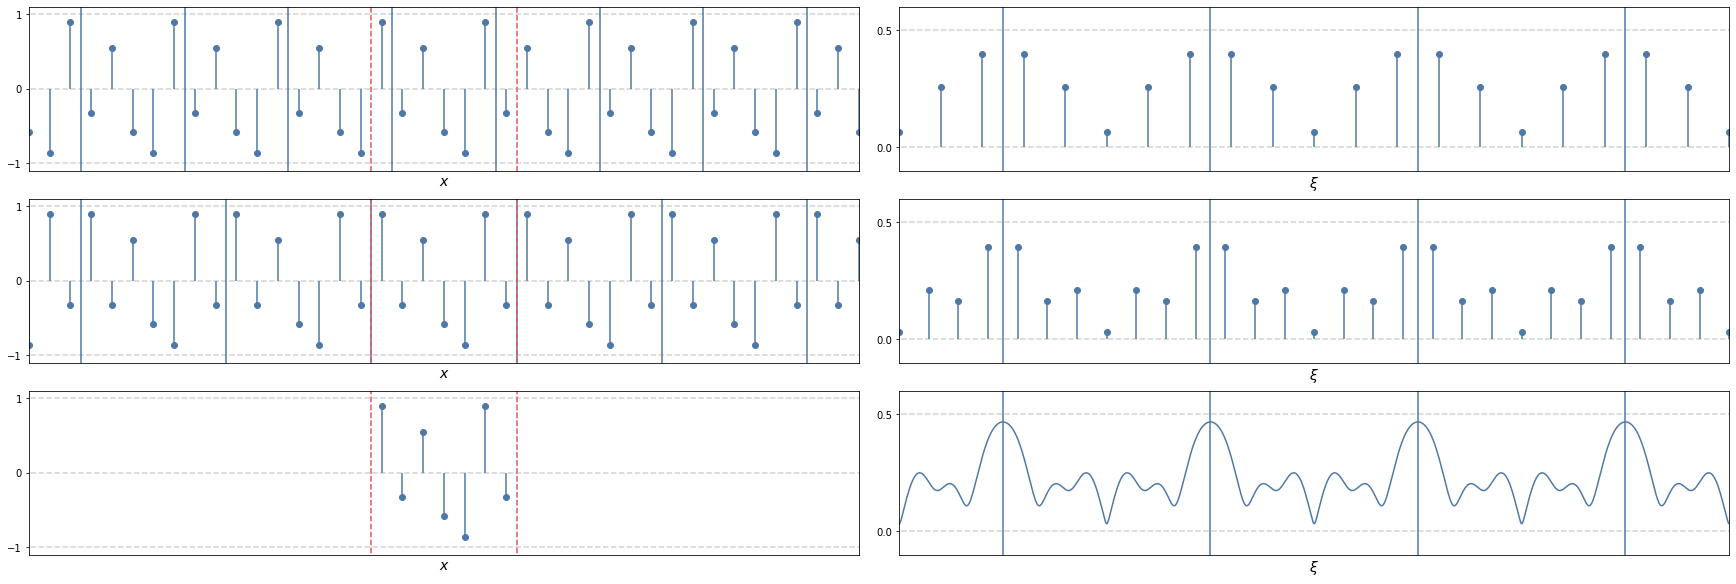

In [6]:
x_r = sampling_coordinates(5 * 7 * 11, 5 * 7 * 11)
x_a = sampling_coordinates(11, 5 * 11)
x_b = sampling_coordinates(11, 7 * 11)

samples = np.array([-0.33, 0.55, -0.58, -0.86, 0.89])
samples_ = samples[(4, 0, 1, 2, 3, 4, 0),]

spectrum_a = scipy_fft.fftshift(scipy_fft.fft(scipy_fft.ifftshift(samples)))/5
spectrum_b = scipy_fft.fftshift(scipy_fft.fft(scipy_fft.ifftshift(samples_)))/7
spectrum = scipy_fft.fftshift(scipy_fft.fft(scipy_fft.ifftshift(samples_), 999))/7

samples_a = np.tile(samples, 7 * 11)
samples_b = np.tile(samples_, 5 * 11)

fig, axs = pyplot.subplots(3, 2, constrained_layout=True, figsize=(24, 8))

for ax in axs[:, 0]:
    ax.set_xlabel(r'$x$', fontsize=14)
    ax.set_xticks([])
    ax.set_xlim(-20, 20)
    ax.set_yticks([-1.0, 0.0, 1.0])
    ax.set_ylim(-1.1, 1.1)
    ax.hlines([-1.0, 0.0, 1.0], -100, 100, linestyle='dashed', color='lightgrey', zorder=-1)

for ax in axs[:, 1]:
    ax.set_xlabel(r'$\xi$', fontsize=14)
    ax.set_xticks([])
    ax.set_xlim(-2, 2)
    ax.set_yticks([0.0, 0.5])
    ax.set_ylim(-0.1, 0.6)
    ax.hlines([0.0, 0.5], -100, 100, linestyle='dashed', color='lightgrey', zorder=-1)

[ln.set_color('lfd:signal') for ln in axs[0, 0].stem(x_r, samples_a, basefmt='none')[0:2]]
[ln.set_color('lfd:signal') for ln in axs[1, 0].stem(x_r, samples_b, basefmt='none')[0:2]]
[ln.set_color('lfd:signal') for ln in axs[2, 0].stem(sampling_coordinates(7, 7), samples_, basefmt='none')[0:2]]

axs[0, 0].plot(np.repeat(x_a, 3) - 5/2, [-10, 10, np.nan]*11, color='lfd:signal')
axs[1, 0].plot(np.repeat(x_b, 3) - 7/2, [-10, 10, np.nan]*11, color='lfd:signal')

axs[0, 0].plot(np.repeat([0, 7], 3) - 7/2, [-10, 10, np.nan]*2, linestyle='dashed', color='lfd:retina')
axs[1, 0].plot(np.repeat([0, 7], 3) - 7/2, [-10, 10, np.nan]*2, linestyle='dashed', color='lfd:retina')
axs[2, 0].plot(np.repeat([0, 7], 3) - 7/2, [-10, 10, np.nan]*2, linestyle='dashed', color='lfd:retina')

[ln.set_color('lfd:signal') for ln in axs[0, 1].stem(sampling_coordinates(5 * 11, 11), np.tile(np.abs(spectrum_a), 11), basefmt='none')[0:2]]
[ln.set_color('lfd:signal') for ln in axs[1, 1].stem(sampling_coordinates(7 * 11, 11), np.tile(np.abs(spectrum_b), 11), basefmt='none')[0:2]]

axs[2, 1].plot(sampling_coordinates(999 * 11, 11), np.tile(np.abs(spectrum), 11), color='lfd:signal')

axs[0, 1].plot(np.repeat(sampling_coordinates(11, 11), 3) - 0.5, [-10, 10, np.nan]*11, color='lfd:signal')
axs[1, 1].plot(np.repeat(sampling_coordinates(11, 11), 3) - 0.5, [-10, 10, np.nan]*11, color='lfd:signal')
axs[2, 1].plot(np.repeat(sampling_coordinates(11, 11), 3) - 0.5, [-10, 10, np.nan]*11, color='lfd:signal')

pass